### SIT731 Task 1.4P: Weather Data Analysis
### Name: Bhuvan Purushothaman Subramani
### Student ID: 224113776
### Email: s224113776@deakin.edu.au
### Course: SIT731 (Postgraduate)


## Introduction
#### This report presents an analysis of weather data from three NYC airports (LGA, JFK, EWR) during 2013.
#### The objective is to process and analyze meteorological data using pandas, including unit conversions, time-based aggregations, visualization, and data cleaning.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Load the dataset
data = pd.read_csv('weather.csv')
data.head()

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,1/1/2013 1:00
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,1/1/2013 2:00
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,1/1/2013 3:00
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,1/1/2013 4:00
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,1/1/2013 5:00


In [25]:
# --- Unit Conversion ---
# Convert temp and dewp from Fahrenheit to Celsius
data['temp'] = (data['temp'] - 32) * 5/9
data['dewp'] = (data['dewp'] - 32) * 5/9

# Convert precip (inches to mm), visib (miles to meters), wind_speed & wind_gust (mph to m/s)
data['precip'] = data['precip'] * 25.4
data['visib'] = data['visib'] * 1609.34
data['wind_speed'] = data['wind_speed'] * 0.44704
data['wind_gust'] = data['wind_gust'] * 0.44704

All key columns have been converted from imperial to metric units: temperature to °C, precipitation to mm, visibility to meters, and wind speeds to m/s.

### Compute the average daily wind speed
The goal of this step is to compute the average daily wind speed at LaGuardia Airport (LGA). This is achieved by grouping the data by year, month, and day, and calculating the mean wind speed for each day.

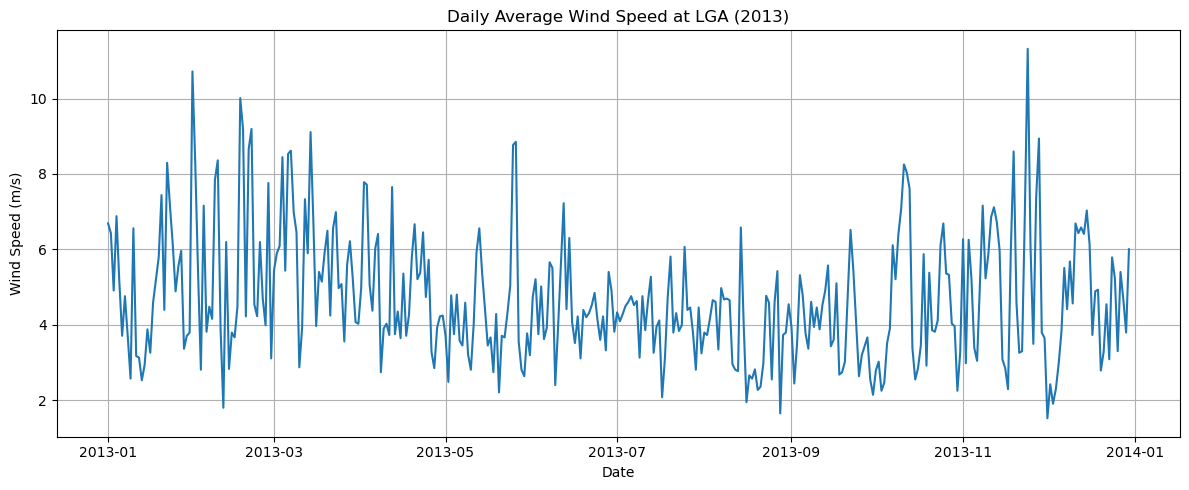

In [27]:
# --- Daily Mean Wind Speeds at LGA ---
lga_daily_wind = data[data['origin'] == 'LGA'].groupby(['year','month','day'])['wind_speed'].mean().reset_index()
lga_daily_wind['date'] = pd.to_datetime(lga_daily_wind[['year','month','day']])

# --- Plot Daily Wind Speeds at LGA ---
plt.figure(figsize=(12, 5))
plt.plot(lga_daily_wind['date'], lga_daily_wind['wind_speed'])
plt.title('Daily Average Wind Speed at LGA (2013)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Discussion
The plot indicates seasonal fluctuations in wind speed, with noticeable increases in wind speed during the winter months. This is consistent with weather patterns typical in northeastern regions of the U.S.

### Identify the 10 Windiest Days at LGA

In this step, we identify the top 10 windiest days at LGA by sorting the daily wind speed data in descending order. This will allow us to pinpoint the extreme weather events of the year.

In [29]:
# --- Ten Windiest Days at LGA ---
top10_windiest = lga_daily_wind.sort_values(by='wind_speed', ascending=False).head(10)
print(top10_windiest[['date', 'wind_speed']])

          date  wind_speed
327 2013-11-24   11.317783
30  2013-01-31   10.717598
47  2013-02-17   10.010236
51  2013-02-21    9.192903
48  2013-02-18    9.174264
72  2013-03-14    9.109958
331 2013-11-28    8.938477
145 2013-05-26    8.852736
144 2013-05-25    8.766995
50  2013-02-20    8.659819


### Monthly Wind Speed Across All Airports

Before calculating monthly wind speed averages, we handle any outliers by replacing extreme values with NaN. This ensures that the average monthly wind speeds are not skewed by anomalous data points.

In [32]:
# --- Monthly Mean Wind Speeds (All Airports) ---
# Detect and replace outlier
wind_max = data['wind_speed'].max()
outlier_index = data['wind_speed'].idxmax()
data.loc[outlier_index, 'wind_speed'] = np.nan

# Monthly mean wind speed per airport
monthly_wind = data.groupby(['origin', 'year', 'month'])['wind_speed'].mean().reset_index()
monthly_wind['date'] = pd.to_datetime(monthly_wind[['year', 'month']].assign(day=1))

### Plot Monthly Wind Speeds by Airport

In this step, we visualize the monthly wind speed averages for each of the three airports (LGA, JFK, EWR). This plot will help us compare the seasonal variations in wind speed across the different airports.

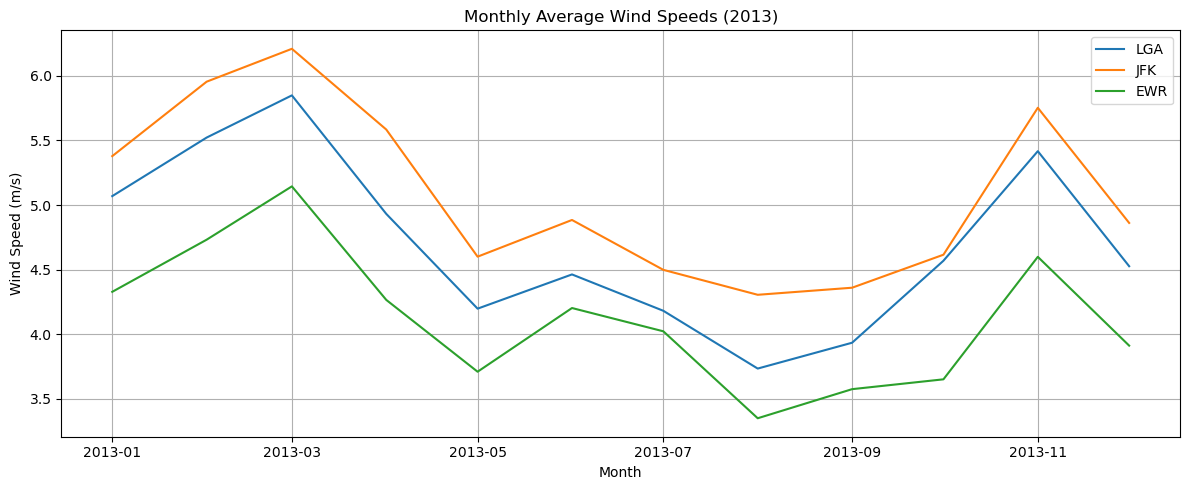

In [34]:
# --- Plot Monthly Wind Speeds for All Airports ---
plt.figure(figsize=(12, 5))
for airport in ['LGA', 'JFK', 'EWR']:
    subset = monthly_wind[monthly_wind['origin'] == airport]
    plt.plot(subset['date'], subset['wind_speed'], label=airport)

plt.title('Monthly Average Wind Speeds (2013)')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Temperature Interpolation at JFK
# Identify missing timestamps for JFK
jfk = data[data['origin'] == 'JFK'].copy()
jfk['datetime'] = pd.to_datetime(jfk[['year','month','day','hour']])
jfk.set_index('datetime', inplace=True)

# Create a full datetime index for 2013 hourly data
full_index = pd.date_range(start='2013-01-01', end='2013-12-31 23:00:00', freq='h')
jfk = jfk.reindex(full_index)
jfk['origin'] = 'JFK'

# Interpolate temperature linearly
jfk_interp = jfk.copy()
jfk_interp['temp'] = jfk_interp['temp'].interpolate(method='linear')

# Daily average temperatures: original vs interpolated
daily_temp_orig = jfk['temp'].resample('D').mean()
daily_temp_interp = jfk_interp['temp'].resample('D').mean()


### Plot Original vs Interpolated Temperature

We now compare the original and interpolated daily temperature data for JFK to visually assess the interpolation's accuracy and the overall temperature trend throughout the year.

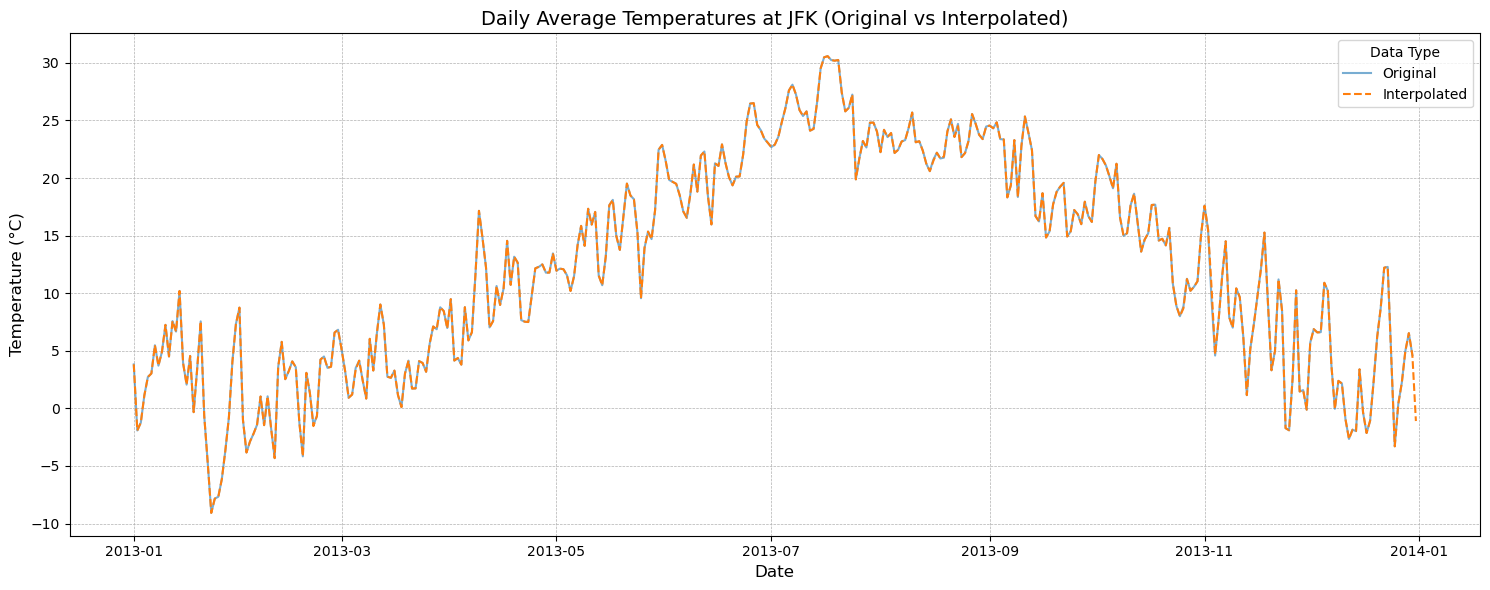

In [38]:
# --- Plot Comparison: Original vs Interpolated Temperatures ---
plt.figure(figsize=(15, 6))
plt.plot(daily_temp_orig.index, daily_temp_orig.values, label='Original', color='tab:blue', alpha=0.6)
plt.plot(daily_temp_interp.index, daily_temp_interp.values, label='Interpolated', color='tab:orange', linestyle='--')
plt.title('Daily Average Temperatures at JFK (Original vs Interpolated)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(title='Data Type')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The interpolated temperature data closely matches the original data, with minimal differences. This indicates that the interpolation technique was effective in filling the missing data.

### Conclusion

This report demonstrates a comprehensive approach to processing and analyzing weather data using Python. We successfully converted units, handled missing data, computed daily and monthly averages, visualized wind speeds, and identified extreme weather events. The techniques used in this analysis can be extended to other types of environmental data.

### Possible Extensions

Analyze other weather variables like humidity and air pressure.
Compare seasonal variations in weather patterns across different years.
Investigate the relationship between weather conditions and airport flight delays.
Use machine learning models to predict future weather conditions based on historical data.